In [1]:
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import RepeatedKFold
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data = data_load.load_turbine_standardized_data_without_time(
    "data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv")
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.normalize_data(data)
data = np.array(data, dtype='float32')

In [3]:
epochs = 3000
k = 10
kf = RepeatedKFold(n_splits=k, n_repeats=1)
i=0

for train, test in kf.split(data):
    ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
    loss = nn.MSELoss()
    # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
    optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
    X_train, X_test = data[train], data[test]
    for epoch in range(epochs):
        print(f"\n=====epoch {epoch}/{epochs}=====")
        train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
                          batch_size=30000)

    res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
    i += 1
    if i == 1:
        break


=====epoch 0/3000=====
loss: 0.954606  [23457/23457]

=====epoch 1/3000=====
loss: 0.953600  [23457/23457]

=====epoch 2/3000=====
loss: 0.952636  [23457/23457]

=====epoch 3/3000=====
loss: 0.951471  [23457/23457]

=====epoch 4/3000=====
loss: 0.949944  [23457/23457]

=====epoch 5/3000=====
loss: 0.947905  [23457/23457]

=====epoch 6/3000=====
loss: 0.944985  [23457/23457]

=====epoch 7/3000=====
loss: 0.940767  [23457/23457]

=====epoch 8/3000=====
loss: 0.934605  [23457/23457]

=====epoch 9/3000=====
loss: 0.925811  [23457/23457]

=====epoch 10/3000=====
loss: 0.913530  [23457/23457]

=====epoch 11/3000=====
loss: 0.896457  [23457/23457]

=====epoch 12/3000=====
loss: 0.873170  [23457/23457]

=====epoch 13/3000=====
loss: 0.842932  [23457/23457]

=====epoch 14/3000=====
loss: 0.806506  [23457/23457]

=====epoch 15/3000=====
loss: 0.767736  [23457/23457]

=====epoch 16/3000=====
loss: 0.736161  [23457/23457]

=====epoch 17/3000=====
loss: 0.709213  [23457/23457]

=====epoch 18/3000=

[14.221803 11.643497 34.297344 ... 20.83447  14.487612 42.75851 ]


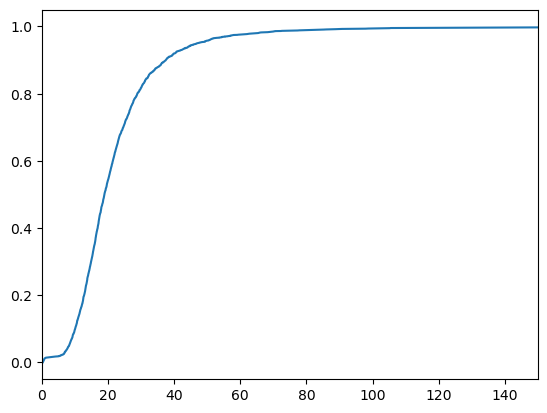

In [10]:

print(res)
plt.hist(res, bins=200)
plt.show()